In [8]:
%pip uninstall torch torchtext -y
%pip install torch torchtext

Found existing installation: torch 2.4.1Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.



Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchtext-0.18.0-cp312-cp312-win_amd64.whl.metadata (7.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchtext-0.18.0-cp312-cp312-win_amd64.whl (2.0 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.19.1 requires torch==2.4.1, but you have torch 2.5.1 which is incompatible.


Training LSTM Model...
Epoch 1, Loss: 0.4110
Epoch 2, Loss: 0.2243
Epoch 3, Loss: 0.0715
Epoch 4, Loss: 0.0623
Epoch 5, Loss: 0.0451
Epoch 6, Loss: 0.0442
Epoch 7, Loss: 0.0378
Epoch 8, Loss: 0.0346
Epoch 9, Loss: 0.0297
Epoch 10, Loss: 0.0225
Epoch 11, Loss: 0.0155
Epoch 12, Loss: 0.0092
Epoch 13, Loss: 0.0061
Epoch 14, Loss: 0.0057
Epoch 15, Loss: 0.0059
Epoch 16, Loss: 0.0058
Epoch 17, Loss: 0.0059
Epoch 18, Loss: 0.0057
Epoch 19, Loss: 0.0055
Epoch 20, Loss: 0.0056
Epoch 21, Loss: 0.0054
Epoch 22, Loss: 0.0054
Epoch 23, Loss: 0.0054
Epoch 24, Loss: 0.0057
Epoch 25, Loss: 0.0055
Epoch 26, Loss: 0.0054
Epoch 27, Loss: 0.0055
Epoch 28, Loss: 0.0055
Epoch 29, Loss: 0.0055
Epoch 30, Loss: 0.0052
Epoch 31, Loss: 0.0053
Epoch 32, Loss: 0.0053
Epoch 33, Loss: 0.0055
Epoch 34, Loss: 0.0054
Epoch 35, Loss: 0.0052
Epoch 36, Loss: 0.0057
Epoch 37, Loss: 0.0057
Epoch 38, Loss: 0.0055
Epoch 39, Loss: 0.0052
Epoch 40, Loss: 0.0052
Epoch 41, Loss: 0.0052
Epoch 42, Loss: 0.0052
Epoch 43, Loss: 0.00

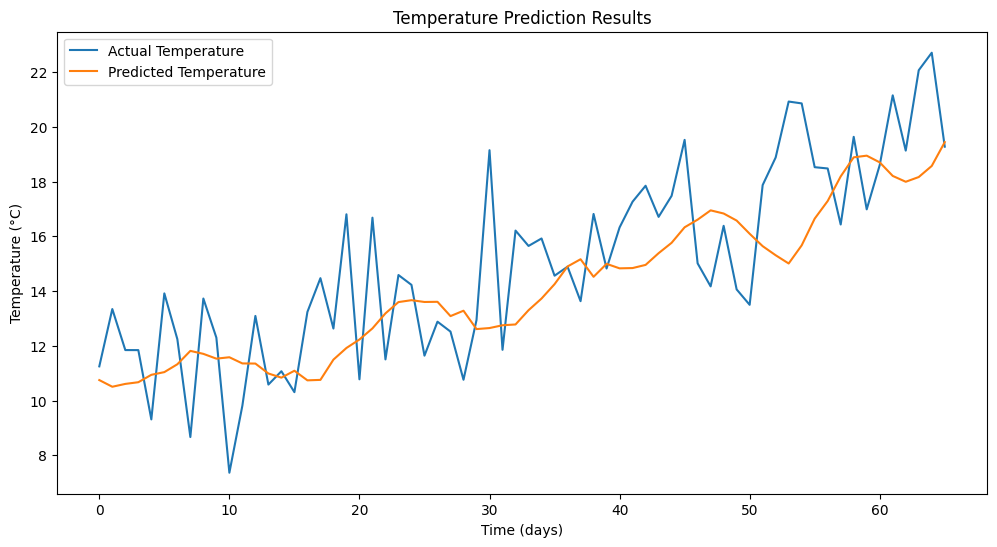

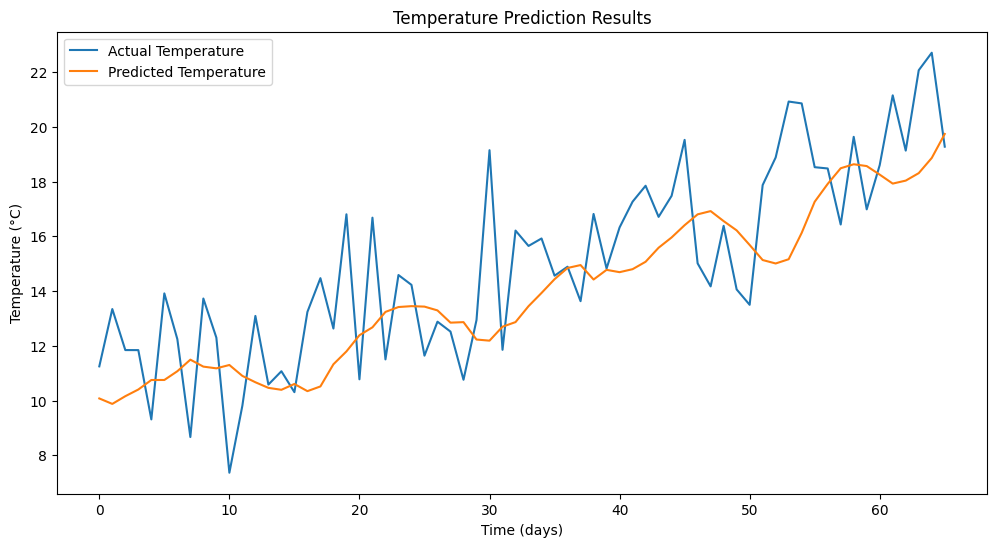

LSTM MSE: 6.0989
GRU MSE: 6.1833


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Data Preparation
class WeatherDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length=7):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], 
                self.data[idx+self.sequence_length])

def prepare_weather_data():
    # Generate sample weather data (replace with real data)
    dates = pd.date_range(start='2023-01-01', end='2023-12-31')
    temperatures = np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 10 + 20
    temperatures += np.random.normal(0, 2, len(dates))  # Add noise
    
    # Normalize data
    scaler = MinMaxScaler()
    normalized_temps = scaler.fit_transform(temperatures.reshape(-1, 1))
    
    # Split into train and test
    train_size = int(len(normalized_temps) * 0.8)
    train_data = normalized_temps[:train_size]
    test_data = normalized_temps[train_size:]
    
    return train_data, test_data, scaler

# 2. Model Definitions
class WeatherLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

class WeatherGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                         batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.linear(gru_out[:, -1, :])

# 3. Training Function
def train_weather_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequence, target in train_loader:
            optimizer.zero_grad()
            output = model(sequence)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

# 4. Evaluation and Visualization
def evaluate_and_visualize(model, test_loader, scaler):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for sequence, target in test_loader:
            output = model(sequence)
            predictions.append(output.numpy())
            actuals.append(target.numpy())
    
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual Temperature')
    plt.plot(predictions, label='Predicted Temperature')
    plt.title('Temperature Prediction Results')
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()
    
    mse = np.mean((predictions - actuals) ** 2)
    return mse

# 5. Main Execution
def run_experiment():
    # Prepare data
    train_data, test_data, scaler = prepare_weather_data()
    sequence_length = 7
    
    train_dataset = WeatherDataset(train_data, sequence_length)
    test_dataset = WeatherDataset(test_data, sequence_length)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                             batch_size=32, 
                                             shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=1, 
                                            shuffle=False)
    
    # Initialize models
    lstm_model = WeatherLSTM()
    gru_model = WeatherGRU()
    
    # Training parameters
    criterion = nn.MSELoss()
    lstm_optimizer = torch.optim.Adam(lstm_model.parameters())
    gru_optimizer = torch.optim.Adam(gru_model.parameters())
    
    # Train models
    print("Training LSTM Model...")
    train_weather_model(lstm_model, train_loader, criterion, 
                       lstm_optimizer, epochs=50)
    
    print("\nTraining GRU Model...")
    train_weather_model(gru_model, train_loader, criterion, 
                       gru_optimizer, epochs=50)
    
    # Evaluate and compare
    print("\nEvaluating Models...")
    lstm_mse = evaluate_and_visualize(lstm_model, test_loader, scaler)
    gru_mse = evaluate_and_visualize(gru_model, test_loader, scaler)
    
    print(f"LSTM MSE: {lstm_mse:.4f}")
    print(f"GRU MSE: {gru_mse:.4f}")

if __name__ == "__main__":
    run_experiment()